
<img alt='UCL' src="images/ucl_logo.png" align='center'>


[<img src="images/noun_pre_2109128.svg" width="50" align='right'>](035_Weighted_interpolation.ipynb)



# 036 Models


## Introduction

In this session, we will consider the idea of a model in (Environmental) Science and discuss  a few examples.

## Models 

We can think of a model as a 'process' box encapsulating our understanding, or a proposal for our understanding, of some process. Two examples we will cover are:

* a descriptive model of vegetation phenology
* a model of snow-melt

Such models make an *output prediction* will be some variable, or set of variables. For our two example models, these will be:

* LAI as a function of time
* river flow resulting from snow-melt

The **outputs** depend on the mechanics of our model and:

* some set of **driving data** (in our two models this will be simply time, and time and temperature, respectively) 
* some model parameters

The model parameters control the operation of the model. These could be related to the type of vegetation for a phenology model, or terms such as the thickness of snowpack in the case of a snow-melt model. Most often, the parameters will describe *states* and *rates*, for example, the current amount of water in a snowpack (state) or the rate at which water is released from the snowpack into runoff (rate).

![model](images/parameters1.png)

We will generally have access to the driving data for our model, and we will have some set of measurements that correspond to the output, but we may not know the values of the parameters to use.

![model](images/parameters2.png)

How can we use this to provide an estimate of the model parameters? We could make some educated guesses, based on previous experience with the model in different situations ('expert opinion'), and we might also be able to provide reasonable bounds for the parameters, again either based on previous experience with the model or sometimes simply from physical limits (e.g. some parameters cannot be negative). 

What we really want is a more objective way of estimating the parameters. This involves parameter optimisation, which is a whole field of science. We cannot cover that in this course, but we can introduce some of the main ideas to use in our codes.

Before moving on to more 'realistic' models, let's build a simple example model `model` we can learn from. This has two parameters `p[0]` and `p[0]` and a driver that represents time:

In [78]:
# simple model 
def model(driver,param):
    '''2-parameter quadratic model with noise'''
    return param[0] + param[1] * driver * driver

We will generate a dataset `measure` at time samples `tmdriver` to represent our measurements, We generate them with the model with a set of parameters and some additive noise. We will also generate a set of weights for the observations, which we will use to indicate their reliability:

In [130]:
import numpy as np
# time driver every 4 days for measurement
tmdriver = np.arange(0,365,4,dtype=np.int)
# generate a pseudo-measurement
p0 = np.array([0.4,0.0002])
measure = model(tmdriver,p0) + 5*np.random.random(tmdriver.shape)
# just make up some weights for this exercise
measure_weight = (2 + np.random.random(tmdriver.shape))/4
# convert to std for plotting as previously
std = 1./np.sqrt(measure_weight) * 1.96

Now we forget that we know the parameters, make a guess that they are `[0.3,0.0001]`, and use the model to make a prediction `output`. Note that `output` exists every day, whereas the measurements are only every 4 days.

measurements: tmdriver shape (92,)
model output: tdriver shape  (365,)


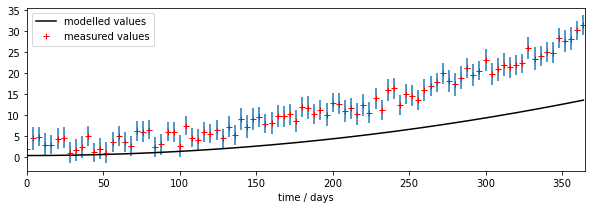

In [131]:
import matplotlib.pyplot as plt

# time driver every day
tdriver = np.arange(0,365,1,dtype=np.int)
# guess parameters
p = np.array([0.3,0.0001])
output  = model(tdriver,p)


# plot
fig, axs = plt.subplots(1,1,figsize=(10,3))
axs.set_xlim(0,365)
axs.plot(tdriver,output,'k',label='modelled values')
axs.errorbar(tmdriver,measure,yerr=std,ls='none')
axs.plot(tmdriver,measure,'r+',label='measured values')
# set legend now
axs.legend(loc='best')
axs.set_xlabel(f'time / days')

print(f'measurements: tmdriver shape {tmdriver.shape}')
print(f'model output: tdriver shape  {tdriver.shape}')

We can see right away that there is a mis-match between the model outputs and the measurements.

### discrepancy and optimisation

We have a set of *observations* that correspond to the model outputs at some time samples. 

A simple operation we can do is to compare these then. We might suppose that a set of parameters that provides a lower discrepancy between observations and modelled values (we will often call this error) is *objectively better* than one with a poorer match. In that sense, what we would need to do would be to search for a set of parameters that which has the minimum error. Our search for parameters will be guided by any bounds we set. Then all we need to do is write some computer code that considers different values of the parameters and reports on the best (the optimal) match.


![model](images/parameters3.png)

That is a reasonable approach, and one we will take in these notes. We should be aware that when we do Science however, we need to take into account uncertainty, and also that there might be other constraints we want to put on the problem.

Uncertainty manifests itself at all stages of modelling and optimisation: the model itself will be uncertain, because of its nature as an abstraction of some process; the drivers will often be uncertain in their ability to the conditions at the actual place and time we are doing the modelling; and the measurements will be uncertain. We have treated uncertainty in other sections of these notes by applying a weight to observations, and we can take the same approach here. When we calculate error, for instance as the root mean square error between model predictions (output) and measurement, we can weight this to give a weighted error.

Before we can calculate the (weighted) error, we need to treat the outputs so that they match the time samples of the measurements. We can either match the observations to the measurements, or the measurements to the observations. The best approach with depend on circumstances, but it is often easiest to match the measurements to the observations:

In [166]:
# tmdriver time locations for measurements
# tdriver time locations for model outputs

# reconcile the model outputs 
# and measurements into same shape
# find the indices of the measurements
location_array = np.zeros_like(measure,dtype=np.int)
# populate location_array with indices of where measurement is
for i,t in enumerate(tmdriver):
    location = np.where(tdriver == t)
    if len(location[0]):
        location_array[i] = location[0][0]

In [168]:
# now mapping output to sample_output is easy
sample_output = output[location_array]

In [163]:
# now we can calculate the weighted discrepency 
error = (sample_output - measure)*measure_weight
error2 = error**2
rmse = np.sqrt(np.mean(error2))
print(f'RMSE: {rmse} for parameters {p}')

RMSE: 5.161766904692453 for parameters [3.e-01 1.e-04]


measurements: measure shape (92,)
model output: output shape  (365,)
sample_output shape          (92,)


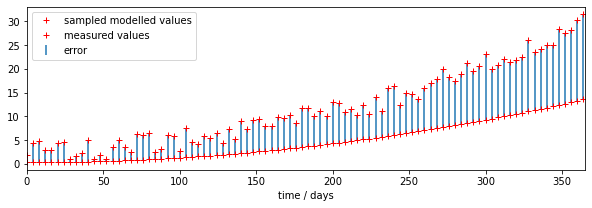

In [164]:
# plot
fig, axs = plt.subplots(1,1,figsize=(10,3))
axs.set_xlim(0,365)
axs.plot(tmdriver,sample_output,'r+',label='sampled modelled values')
axs.plot(tmdriver,measure,'r+',label='measured values')
# plot the discrepencies in orange
axs.errorbar(tmdriver,measure,\
             yerr=[measure-measure,sample_output-measure],ls='none',\
             label='error')

# set legend now
axs.legend(loc='best')
axs.set_xlabel(f'time / days')

print(f'measurements: measure shape {measure.shape}')
print(f'model output: output shape  {output.shape}')
print(f'sample_output shape          {sample_output.shape}')

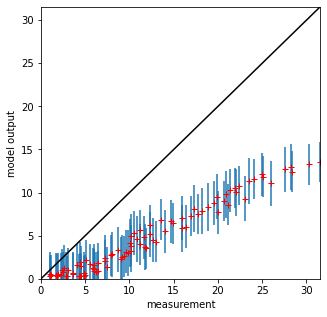

In [165]:
# scatter plot
fig, axs = plt.subplots(1,1,figsize=(5,5))
# max value over all
maxvalue = np.array([measure,sample_output]).max()
axs.set_xlim(0,maxvalue)
axs.set_ylim(0,maxvalue)

axs.plot(measure,sample_output,'r+')
axs.errorbar(measure,sample_output,yerr=std,ls='none')

axs.set_ylabel(f'model output')
axs.set_xlabel(f'measurement')
# 1:1 line
axs.plot([0,maxvalue],[0,maxvalue],'k')

### Varying the parameters

We have seen how, once we have aligned the model outputs and observations, we can calculate a weighted measure if error, RMSE here. So, so some given set of measurements, a model, and a set of model parameters, we can calculate the error:

![model](images/parameters4.png)

In [176]:
# get measurement mask
location_array = np.zeros_like(measure,dtype=np.int)
# populate location_array with indices of where measurement is
for i,t in enumerate(tmdriver):
    location = np.where(tdriver == t)
    if len(location[0]):
        location_array[i] = location[0][0]
              
def get_rmse(location_array,driver,p,measure,weight,mod=model):
    ''' get model-measurement error '''
    # time driver every day but sample only location_array
    output  = mod(driver,p)[location_array]
    error = (sample_output - measure)*weight
    error2 = error**2
    return np.sqrt(np.mean(error2))

p = np.array([0.3,0.0001])
tdriver = np.arange(0,365,1,dtype=np.int)
rmse = get_rmse(location_array,tdriver,p,measure,measure_weight)

print(f'RMSE: {rmse} for parameters {p}')

RMSE: 5.161766904692453 for parameters [3.e-01 1.e-04]


Lets generate a 2-D grid that we will use to sample the parameters:

2d parameter grid


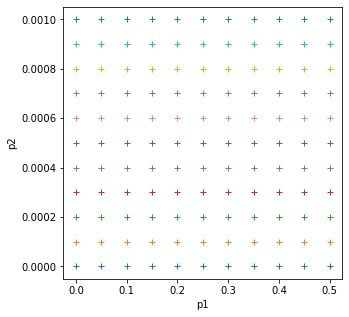

In [200]:
p1_range = np.array([0.0,0.5])
p2_range = np.array([0.0,0.001])

# number of samples
N = 10
# define a 2D grid of indices
p1,p2 = np.indices((N+1,N+1))/float(N)
# scale to parameter range
p1 = p1 * (p1_range[1] - p1_range[0]) + p1_range[0]
p2 = p2 * (p2_range[1] - p2_range[0]) + p2_range[0]

# plot it
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.plot(p1,p2,'+')
axs.set_xlabel('p1')
axs.set_ylabel('p2')

print('2d parameter grid')

Now, calculate the RMSE for each point on the grid:

In [207]:
model(np.expand_dims(tdriver, axis=(0,1)),np.expand_dims(np.array([p1,p2],axis=2)))

TypeError: 'axis' is an invalid keyword argument for array()

In [208]:
np.expand_dims(tdriver, axis=(0,1))

array([[[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
          12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
          24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
          36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
          48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
          60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
          72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
          96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
         108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
         120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
         132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
         144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
         156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
         168, 169, 170, 171, 172, 

In [212]:
np.expand_dims(p2,axis=2).shape

(11, 11, 1)

In [216]:
(np.expand_dims(tdriver, axis=(0,1)) + np.expand_dims(p2,axis=2)).shape

(11, 11, 365)

# 036 Model Fitting 

We use many models in Science. Typical models in Environmental science will have 


### Test

You should run a [NASA account test](004_Accounts.ipynb) if you have not already done so.

Fit to LAI curves ...

In the previous session, we looked at fitting linear models to observations. While this is a very common task, complex processes might require models which are non-linear.

One non-linear model is modelling LAI as a function of time (or temperature). In the Nothern Hemisphere, and for temperate latitudes, there is a clear seasonal cycle in vegetation, particularly visible in leaf area index (LAI). LAI dynamics can possibly be depicted by a "double logistic" curve. Mathematically, the double logistic looks like this


![A double logistic](https://camo.githubusercontent.com/7a664a29ec5bc190d71d8ba5ec391bcf98848df7/687474703a2f2f777777322e67656f672e75636c2e61632e756b2f7e706c657769732f67656f67673132342f5f696d616765732f7a68616e67312e706e67)

Mathematically, the function predicts the e.g. LAI (or some vegetation index) as

$$
y = p_0 - p_1\cdot\left[\frac{1}{1+\exp\left(p_2\cdot(t-p_3)\right)} + \frac{1}{1+\exp\left(-p_4\cdot(t-p_5)\right)} - 1\right].
$$

If we inspect this form, we can probably guess that $p_0$ and $p_1$ scale the vertical span of the function, whereas $p_3$ and $p_5$ are some sort of temporal shift, and the remaining parameters $p_2$ and $p_4$ control the slope of the two flanks. Something that will give rise to a self-respecting LAI curve might be

* $p_0= 0.1$
* $p_1= 2.5$
* $p_2=0.19$
* $p_3= 120$
* $p_4= 0.13$
* $p_5= 220$

<div class="alert alert-danger">
<p>Write a function that produces the double logistic when passed an array of time steps (e.g. 1 to 365), and an array with six parameters.</p>
<p>Do some plots and try to get some intuition on the model parameters!</p>
</div>



In [1]:
# All imports go here. Run me first!
import datetime
from pathlib import Path  # Checks for files and so on
import numpy as np  # Numpy for arrays and so on
import pandas as pd
import sys
import matplotlib.pyplot as plt  # Matplotlib for plotting
# Ensure the plots are shown in the notebook
%matplotlib inline

import gdal
import osr
import numpy as np
%matplotlib inline

## A synthetic experiment

A first step is to do a synthetic experiment. This has the marked advantage of being a situation where we're in control of everything. 

Text(0,0.5,'LAI')

/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


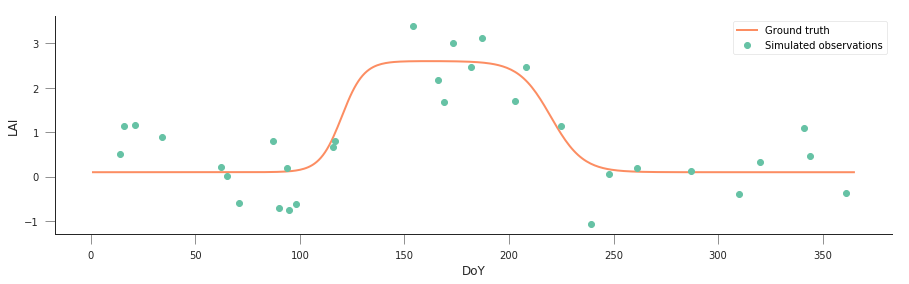

In [2]:

t = np.arange(1, 366)
p = np.array([0.1, 2.5, 0.19, 120, 0.13, 220])
y = dbl_sigmoid_function(p, t)
yn = y + np.random.randn(len(t))*0.6

selector = np.random.rand(365)

passer = np.where(selector > 0.9, True, False)

tn = t[passer]
yn = yn[passer]

fig = plt.figure(figsize=(15, 4))
_ = plt.plot(t, y, '-', label="Ground truth")
_ = plt.plot(tn, yn, 'o', label="Simulated observations")
plt.legend(loc="best")
plt.xlabel("DoY")
plt.ylabel("LAI")



We know that the "true parameters" are given by `p = np.array([0.1, 2.5, 0.19, 120, 0.13, 220])`, but we see that the data is quite noisy and has significant gaps. As per last session, we could try to modify the parameters "by hand", and see how far we get, but given that it's 6, with different ranges, it looks a bit daunting. Also, we'd need to assess how good the solution is for a particular set of parameters, in other words, select a metric to quantify the goodness of fit.

It is useful to consider a model of the incomplete, noisy observations of LAI ($y_n$) and the true value of LAI, $y$. For overlapping time steps, the noisy data are just the "true" data plus some random Gaussian value with zero mean and a given variance $\sigma_{obs}^2$ (in the experiment above, $\sigma_{obs}=0.6$):

$$
y_n^{i} = y^{i} + \mathcal{N}(0, \sigma_{obs}^2).
$$

Rearranging things, we have that $y_n - y$ should be a zero mean Gaussian distribution with known variance. We have assumed that our model is $f(\vec{p})=y$, so we can write the *likelihood function*, $l(\vec{p})$

$$
l(\vec{p}) = \left[\frac{1}{\sqrt{2\pi\sigma_{obs}^2}}\right]^{N}\displaystyle{\prod_{i=1}^{N} \exp\left[-\frac{(y_n^{i}-f(\vec{p})^{i})^2}{2\sigma_{obs}^2}   \right]}.
$$

It is convenient to take a logarithm of $l(\vec{p})$, so that we have the **log-likelihood**:

$$
L(\vec{p}) = -\displaystyle{\sum_{i=1}^{N} \left[\frac{(y_n^{i}-f(\vec{p})^{i})^2}{2\sigma_{obs}^2}   \right]} + \textrm{Const.}
$$

<div class="alert alert-success">
Think about the likelihood and log-likelihood... Think (and possibly plot) how a negative exponential curve looks like, and what conditions are for some interesting points.
</div>

/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


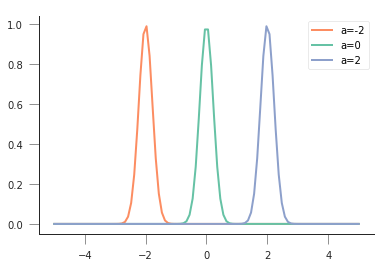

So for a sum of squares, the most likely result would be if all the mismatches were zero, which means that the log-likelihood is 0, and the likelihood, $exp(0)=1$! 

However, the mismatch might not be 0, due to the added noise. So what we're effectively looking for is a **maximum** in the log-likelihood, or a **minimum** of its negative as a function of $\vec{p}$:

$$
\frac{\partial (-L(\vec{p}))}{\partial \vec{p}} \triangleq \min
$$

So, we can try our brute force guessing approach by **minimising the cost function given by $L(\vec{p})$**

<div class="alert alert-danger">
Write the cost function! Test it possibly shifting one parameter over some range of values
</div>

The easiest way to obtain the solution is to use numerical optimisation techniques to minimise the cost function. In scipy, there's [a good selection of function optimisers](https://docs.scipy.org/doc/scipy/reference/optimize.html). We'll be looking at **local** optimisers: these will look for a minimum in the vicinity of a user-given starting point, usually by looking at the gradient of the cost function. The main function to consider here is [`minimise`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize). Basically, `minimize` takes a cost function, a starting point, and maybe extra arguments that are passed to the cost function, and uses one of several algorithms to minimise the cost function. We import it with

```python
    from scipy.optimize import minimize
```

From the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize),
```python
    minimize(fun, x0, args=(), method=None,
             jac=None, hess=None, hessp=None,
             bounds=None, constraints=(), tol=None,
             callback=None, options=None)
```

Basically, `fun` is the name of the cost function. The first parameter you pass to the cost function has to be an array with the parameters that will be used to calculate the cost. `x0` is the starting point. `args` allows you to add extra parameters that are required for the cost function (in our example, these would be `t, y_obs, passer, sigma_obs`).

The `minimize` function returns an object with the 

1. Value of the function at the minimum,
2. The value of the input parameters that attain the minimum,
3. A message telling you whether the optimisation succeeded
4. The number of iterations (`nit`) and total function evaluations (`nfev`)
5. Some diagnostics 





In [ ]:
from scipy.optimize import minimize

In [44]:
from scipy.optimize import minimize

p0 = np.array([0, 5, 0.01, 90, 0.01, 200])

retval = minimize(cost_function, p0, args=(t, yn, passer, 0.6))

print(retval)

print ("********************************************")
if retval.success:
    print("Optimisation successful!")
    print(f"Value of the function at the minimum: {retval.fun:g}")
    print(f"Value of the solution: {str(retval.x):s}")

      fun: 21.342085853280015
 hess_inv: array([[ 1.72923106e-02, -2.15349312e-02,  2.11636346e-03,
         2.98572159e-02,  4.47526187e-03, -5.30376564e-02],
       [-2.15349312e-02,  1.13986002e-01, -4.73509772e-02,
         5.02075575e-01, -5.17466259e-02, -4.55944527e-01],
       [ 2.11636346e-03, -4.73509772e-02,  7.51102753e-02,
        -5.51690150e-01,  2.61989471e-02,  2.73170740e-01],
       [ 2.98572159e-02,  5.02075575e-01, -5.51690150e-01,
         9.54855368e+00, -3.19209970e-01, -3.30673084e+00],
       [ 4.47526187e-03, -5.17466259e-02,  2.61989471e-02,
        -3.19209970e-01,  5.74465509e-02,  3.44439220e-01],
       [-5.30376564e-02, -4.55944527e-01,  2.73170740e-01,
        -3.30673084e+00,  3.44439220e-01,  8.29858275e+00]])
      jac: array([ 4.76837158e-07,  4.52995300e-06, -4.76837158e-07, -4.76837158e-07,
        9.53674316e-07,  4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 616
      nit: 63
     njev: 77
   status: 0
  success

<div class="alert alert-danger">
Do some synthetic experiments. For example:
<ol>
    <li> Change the true parameters and see how the solution tracks the change.</li>
    <li> Increase the added variance</li>
    <li> Reduce or increase the number of observations</li>
</ol>

Use these experiments to challenge your understanding of the problem: Try to think what the expected result of these changes is, and write a set of functions that simplify the exploration.
</div>






[<img src="images/noun_post_2109127.svg" width="50" align='right'>](016_Python_for.ipynb)
[<img src="images/noun_pre_2109128.svg" width="50" align='right'>](018_Python_xxx.ipynb)
